Après avoir vu les différents types de nettoyage du texte possible dans le notebook précédent,
</br>
</br>(1) Nous allons maintenant étudier comment extraire l'information du texte pour le traitement ultérieur par des modèles de machine learning
</br>
</br>(2) Puis, nous modéliserons nos sujet avec une méthode non supervisé : Lattent Dirichlet Allocation (LDA).
</br>
</br>(3) Enfin, nous utiliserons des méthodes supervisées afin d'assigner à chaque document les tags associés.

https://www.kaggle.com/code/miljan/predicting-tags-for-stackoverflow/notebook

# <font color = Green>Partie 1 : Création de features</font>

## <font color = purple>1. Préléminaires</font>

### <font color = grey>1.1 Contexte</font>

Cette Partie est dédiée à la Transformation de notre Texte et donc à la création de features exploitable pour le Machine Learning.
</br>Nous allons Testser différentes méthodes de représentation de nos document :
</br>
</br>&emsp;<b>(1) Méthodes de comptage direct</b> (fréquence ou tf-idf) :
</br>&emsp;&ensp;- Approche Bag of Words
</br>&emsp;&ensp;- Approche n-gram (Bag of words généralisé)
</br>&emsp;&ensp;- Approche TF-IDF
</br>
</br>&emsp;<b>(2) Méthode plongement de mot :</b>
</br>&emsp;&ensp;- Word2Vec
</br>&emsp;&ensp;- Doc2Vec
</br>
</br>&emsp;<b>(3) BERT</b>
</br>
</br>&emsp;<b>(4) USE</b>


### <font color = grey>1.2 Librairies</font>

In [1]:
# Classiques
import os, sys, time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Text processing
import nltk


# Model
from sklearn.feature_extraction.text import CountVectorizer #pour le bag of word et n-grams
from sklearn.feature_extraction.text import TfidfVectorizer #pour le tf idf
from sklearn.manifold import TSNE #pour le tsne
from sklearn.decomposition import LatentDirichletAllocation #pour la lda

#Gensim & setup login
import gensim 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) #set up login

import warnings
warnings.filterwarnings("ignore")

### <font color = grey>1.3 Chargement des données</font>

In [2]:
#Chemin de notre fichier source
data = "cleaned/"
os.listdir(data)

#Chargement du Dataframe
fn = data + 'final_df.csv'
df = pd.read_csv(fn)
df.head()

,Title,Body,Tags,title_body,clean_title_body,clean_title,clean_body,clean_tags
0,MyISAM versus InnoDB,I'm working on a projects which involves a lot...,mysql database performance innodb myisam,MyISAM versus InnoDB I'm working on a projects...,myisam versu innodb project involv lot databas...,myisam versu innodb,project involv lot databas write say insert re...,mysql databas perform innodb myisam
1,Recommended SQL database design for tags or ta...,I've heard of a few ways to implement tagging;...,sql database-design tags data-modeling tagging,Recommended SQL database design for tags or ta...,recommend sql databas design tag tag heard way...,recommend sql databas design tag tag,heard way implement tag map tabl tagid itemid ...,sql databas design tag data model tag
2,What is the difference between #include <filen...,What is the difference between using angle bra...,c++ c include header-files c-preprocessor,What is the difference between #include <filen...,differ includ filenam includ filenam differ an...,differ includ filenam includ filenam,differ angl bracket quot includ direct includ ...,includ header preprocessor
3,How do I size a UITextView to its content?,Is there a good way to adjust the size of a UI...,ios cocoa-touch autolayout uikit uitextview,How do I size a UITextView to its content? Is ...,size uitextview content good way adjust size u...,size uitextview content,good way adjust size uitextview conform conten...,io cocoa touch autolayout uikit uitextview
4,Batch file to delete files older than N days,I am looking for a way to delete all files old...,windows date batch-file file-io cmd,Batch file to delete files older than N days I...,batch delet older day look way delet older day...,batch delet older day,look way delet older day batch search around w...,window date batch cmd


-----

## <font color = purple>2. approche Bag of Words</font>

On drop les NaN

In [3]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
rows_with_NaN

,Title,Body,Tags,title_body,clean_title_body,clean_title,clean_body,clean_tags
54,"What does if __name__ == ""__main__"": do?","What does this do, and why should one include ...",python namespaces main python-module idioms,"What does if __name__ == ""__main__"": do? What ...",one includ statement print hello world,NaN,one includ statement print hello world,python namespac main python modul idiom
224,Why do we use Base64?,Wikipedia says\n\nBase64 encoding schemes are ...,algorithm character-encoding binary ascii base64,Why do we use Base64? Wikipedia says\n\nBase64...,wikipedia say encod scheme commonli need encod...,NaN,wikipedia say encod scheme commonli need encod...,algorithm charact encod binari ascii
909,What are .a and .so files?,I'm currently trying to port a C application t...,c unix compilation shared-libraries .a,What are .a and .so files? I'm currently tryin...,current tri port applic aix confus build run a...,NaN,current tri port applic aix confus build run a...,unix compil share librari
1241,push_back vs emplace_back,I'm a bit confused regarding the difference be...,c++ visual-studio-2010 stl c++11 move-semantics,push_back vs emplace_back I'm a bit confused r...,bit confus regard differ void type void const ...,NaN,bit confus regard differ void type void const ...,visual studio stl move semant


In [4]:
df = df.dropna()

# AVEC TITLE POUR LE MOMENT !

In [5]:
#Initialize
CountVec = CountVectorizer(ngram_range=(1,1)) # to use bigrams ngram_range=(2,2)

#transform
Count_data = CountVec.fit_transform(df["clean_title"])

#create dataframe
X_bag_of_words=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names_out())

In [9]:
#affichage
X_bag_of_words.sample(10)

,abbrevi,abl,abort,absolut,abstract,accent,accept,access,accessor,accord,...,yea,year,youtub,yum,yyyi,zero,zeromq,zombi,zone,zoom
1115,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
969,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
501,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
857,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
340,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1191,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
703,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## <font color = purple>3. approche n-gram </font>

stop_words: Since CountVectorizer just counts the occurrences of each word in its vocabulary, extremely common words like ‘the’, ‘and’, etc. will become very important features while they add little meaning to the text. Your model can often be improved if you don’t take those words into account. Stop words are just a list of words you don’t want to use as features. You can set the parameter stop_words=’english’ to use a built-in list. Alternatively you can set stop_words equal to some custom list. This parameter defaults to None.
ngram_range: An n-gram is just a string of n words in a row. E.g. the sentence ‘I am Groot’ contains the 2-grams ‘I am’ and ‘am Groot’. The sentence is itself a 3-gram. Set the parameter ngram_range=(a,b) where a is the minimum and b is the maximum size of ngrams you want to include in your features. The default ngram_range is (1,1).
In a recent project where I modeled job postings online, I found that including 2-grams as features boosted my model’s predictive power significantly. This makes intuitive sense; many job titles such as ‘data scientist’, ‘data engineer’, and ‘data analyst’ are 2 words long.
min_df, max_df: These are the minimum and maximum document frequencies words/n-grams must have to be used as features. If either of these parameters are set to integers, they will be used as bounds on the number of documents each feature must be in to be considered as a feature. If either is set to a float, that number will be interpreted as a frequency rather than a numerical limit. min_df defaults to 1 (int) and max_df defaults to 1.0 (float).
max_features: This parameter is pretty self-explanatory. The CountVectorizer will choose the words/features that occur most frequently to be in its’ vocabulary and drop everything else.
You would set these parameters when initializing your CountVectorizer object as shown below.

In [10]:
#Initialize
CountVec = CountVectorizer(ngram_range=(2,2)) # to use bigrams ngram_range=(2,2)

#transform
Count_data = CountVec.fit_transform(df["clean_title"])

#create dataframe
X_bigram=pd.DataFrame(Count_data.toarray(),columns=CountVec.get_feature_names_out())

In [28]:
X_bigram.sample(10)

,abbrevi net,abl scroll,abort could,absolut path,absolut posit,abstract class,abstract method,accent normal,accept attribut,accept best,...,youtub api,youtub video,yum instal,yyyi javascript,zero date,zombi exist,zone best,zone issu,zoom input,zoom mobil
1393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1304,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1308,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1518,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
758,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1122,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


PRB == Matrice creuse !, peut être regler (sur le net)

## <font color = purple>4. approche TF - IDF </font>

In [29]:
#Initialize
tfidf = TfidfVectorizer(ngram_range=(1,1))
 
#transform
result = tfidf.fit_transform(df["clean_title"])

#create dataframe
X_tfidf=pd.DataFrame(result.toarray(),columns=tfidf.get_feature_names_out())

In [30]:
X_tfidf.sample(10)

,abbrevi,abl,abort,absolut,abstract,accent,accept,access,accessor,accord,...,yea,year,youtub,yum,yyyi,zero,zeromq,zombi,zone,zoom
1611,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
827,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
219,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1296,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.231873,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
928,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1125,0.0,0.0,0.0,0.376043,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1360,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
556,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1637,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
666,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


NMF (autre méthode)

## <font color = purple>5. Plongement de mots avec Word2Vec et  Doc2Vec</font>

### <font color = green>1. Documentation</font>

https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook

https://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/

https://edumunozsala.github.io/BlogEms/jupyter/nlp/classification/embeddings/python/2020/08/15/Intro_NLP_WordEmbeddings_Classification.html#Word-embeddings

<b>Applying the word embedding to a text classification task</b>
Now, we have our word representation, a vector for every word in our vocabulary. But we need to deal with full sentences so we need to create a sentence embedding, basically we need a vector that represent the whole sentence and every feature in the vector will be based on the word embeddings. There are many posibilities and we are notr going to cover this topic, so we apply a very simple method: the ith value in the sentence embedding will be the mean of the ith values in the word embedding of all the words in the sentence.

We will create a class that will contain our vocabulary and glove vectors and then it will transform every review (a sentence in our example) to a vector representation as we describe previously.

https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

https://github.com/RaRe-Technologies/gensim/blob/3c3506d51a2caf6b890de3b1b32a8b85f7566ca5/docs/notebooks/doc2vec-IMDB.ipynb

Sympa : https://linanqiu.github.io/2015/10/07/word2vec-sentiment/

https://linanqiu.github.io/2015/10/07/word2vec-sentiment/

### <font color = green>2. Word2Vec</font>

#### <font color = grey>a. Model</font>

In [31]:
# Create list of tokens
tokens = df["clean_title"].values.tolist()

# Tokenizing strings in list of strings
res = [sub.split() for sub in tokens]

In [32]:
# Initialize model
model = gensim.models.Word2Vec(res, vector_size = 100, window=10, min_count=2, workers=10)

# Train the model
model.train(res,total_examples=len(res),epochs=10)

2022-10-17 14:56:07,156 : INFO : collecting all words and their counts
2022-10-17 14:56:07,156 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-10-17 14:56:07,158 : INFO : collected 2030 word types from a corpus of 8328 raw words and 1671 sentences
2022-10-17 14:56:07,159 : INFO : Creating a fresh vocabulary
2022-10-17 14:56:07,162 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=2 retains 1028 unique words (50.64039408866995%% of original 2030, drops 1002)', 'datetime': '2022-10-17T14:56:07.162323', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'prepare_vocab'}
2022-10-17 14:56:07,163 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=2 leaves 7326 word corpus (87.96829971181556%% of original 8328, drops 1002)', 'datetime': '2022-10-17T14:56:07.163321', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.191

(65335, 83280)

#### <font color = grey>b. Similarité entre les mots</font>

In [33]:
#Observer le vecteur de "use"
model.wv["python"]

array([-0.1653399 ,  0.35387492,  0.06272807,  0.07683088,  0.10408764,
       -0.6008398 ,  0.15346728,  0.6884075 , -0.17324859, -0.06603417,
       -0.21245202, -0.42875198, -0.05762694,  0.12825197,  0.11886377,
       -0.22092761,  0.00969438, -0.3866519 , -0.03466053, -0.58453363,
        0.16916226,  0.12993272,  0.18430786, -0.12366612, -0.1419507 ,
        0.10667771, -0.32484126, -0.34951004, -0.2210636 ,  0.06093941,
        0.33851004,  0.16391717,  0.06453181, -0.06206826, -0.19850117,
        0.3671479 ,  0.00203453, -0.3418623 , -0.2773217 , -0.6720459 ,
        0.04736494, -0.25128263, -0.03233613, -0.07927433,  0.2724138 ,
       -0.07419963, -0.19989623, -0.09086411,  0.17745633,  0.2004094 ,
        0.18448474, -0.3341665 ,  0.00757688,  0.02441483, -0.2961934 ,
        0.24906698,  0.12626415, -0.01691405, -0.38377443,  0.06079949,
        0.14948966,  0.14545004, -0.12239191, -0.12899993, -0.4265291 ,
        0.15256357,  0.14578624,  0.23557256, -0.35711434,  0.37

In [34]:
#Les 6 mots les plus similaire à python
w1 = ["python"]
model.wv.most_similar (positive=w1,topn=6)

[('load', 0.9995328783988953),
 ('io', 0.9995101690292358),
 ('valu', 0.9995100498199463),
 ('app', 0.9994659423828125),
 ('json', 0.9994465112686157),
 ('error', 0.9994300007820129)]

In [35]:
#Les 6 mots les plus similaire à python
w1 = ["java"]
model.wv.most_similar (positive=w1,topn=6)

[('valu', 0.9995467066764832),
 ('load', 0.9995236992835999),
 ('text', 0.9995140433311462),
 ('error', 0.9995064735412598),
 ('chang', 0.9994917511940002),
 ('differ', 0.9994842410087585)]

In [36]:
#Similarité entre 2 mots :
model.wv.similarity(w1="java", w2="javascript")

0.9993716

In [37]:
#Similarité entre 2 mots :
model.wv.similarity(w1="java", w2="python")

0.9994277

In [17]:
#Similarité entre 2 mots identique :
model.wv.similarity(w1="java", w2="java")

1.0

In [41]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['python']}
similar_words

{'python': ['load', 'io', 'valu', 'app', 'json']}

#### <font color = grey>c. Vizualisation TSNE</font>

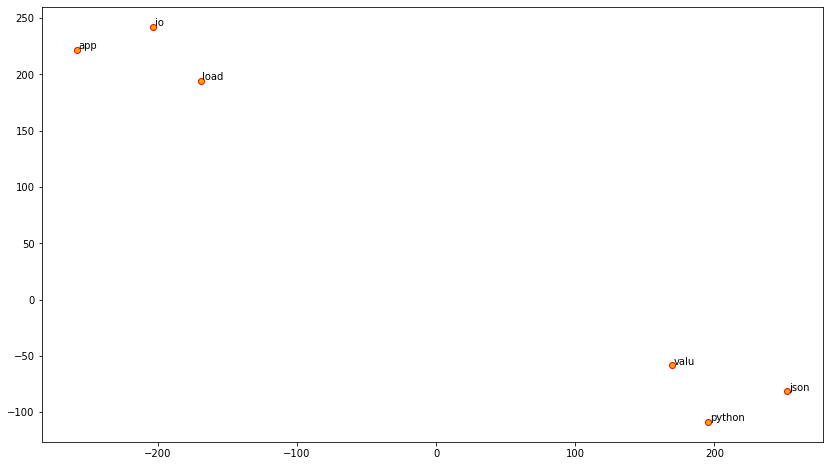

In [42]:
words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

### <font color = green>3. Doc2Vec</font>

DBOW is the doc2vec model analogous to Skip-gram model in word2vec. The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

We will vary the following parameters:

If dm=0, distributed bag of words (PV-DBOW) is used; if dm=1,‘distributed memory’ (PV-DM) is used.
300- dimensional feature vectors.
min_count=2, ignores all words with total frequency lower than this.
negative=5 , specifies how many “noise words” should be drawn.
hs=0 , and negative is non-zero, negative sampling will be used.
sample=0 , the threshold for configuring which higher-frequency words are randomly down sampled.
workers=cores , use these many worker threads to train the model (=faster training with multicore machines).

In [43]:
#Vérification du nb de coeur dispo
import multiprocessing
cores = multiprocessing.cpu_count()
cores

8

In [44]:

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
data = df["clean_title"]
tagged_data = [TaggedDocument(words=_d, tags=[str(i)]) for i, _d in enumerate(data)]

In [45]:
tagged_data[200]

TaggedDocument(words='format unsign long long int printf', tags=['200'])

In [46]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm =1)
  
model.build_vocab(tagged_data)

2022-10-17 14:59:02,293 : INFO : Doc2Vec lifecycle event {'params': 'Doc2Vec(dm/m,d20,n5,w5,s0.001,t3)', 'datetime': '2022-10-17T14:59:02.293032', 'gensim': '4.1.2', 'python': '3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'created'}
2022-10-17 14:59:02,294 : INFO : collecting all words and their counts
2022-10-17 14:59:02,295 : WARNING : Each 'words' should be a list of words (usually unicode strings). First 'words' here is instead plain <class 'str'>.
2022-10-17 14:59:02,296 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2022-10-17 14:59:02,307 : INFO : collected 27 word types and 1671 unique tags from a corpus of 1671 examples and 53003 words
2022-10-17 14:59:02,308 : INFO : Creating a fresh vocabulary
2022-10-17 14:59:02,309 : INFO : Doc2Vec lifecycle event {'msg': 'effective_min_count=1 retains 27 unique words (100.0%% of original 27, drops 0)', 'datetime': '2022-10-17T14:59:02.

In [47]:
df["clean_title"].shape

(1671,)

In [48]:
#creation de la matrice des vecteurs de chaque phrases
X_doc2vec = np.zeros((1671,20)) #20 correpsond au vector_size

for i in range(1671):
    X_doc2vec[i] = model[str(i)]

In [49]:
X_doc2vec

array([[-0.02615408, -0.02989564, -0.04940378, ...,  0.04612811,
        -0.04750933, -0.01729044],
       [-0.01884955,  0.01303691, -0.02845779, ..., -0.04271271,
        -0.01801307,  0.00865812],
       [-0.0102846 , -0.03615022,  0.02092299, ...,  0.01767989,
        -0.02875156,  0.04407407],
       ...,
       [-0.0092081 ,  0.0453164 , -0.03758141, ...,  0.01410308,
        -0.04667521, -0.01426193],
       [ 0.04282513,  0.04463822,  0.00622153, ..., -0.02043825,
        -0.00414624,  0.03259372],
       [ 0.03273497,  0.02404989, -0.00732609, ..., -0.04914112,
         0.02745314, -0.01130791]])

### <font color = green>4. BERT</font>

### <font color = green>3. USE</font>

# <font color = Green>Partie 2 : Approche non supervisée : LDA</font>

## <font color = purple>1. Préléminaires</font>

Dans le monde actuel, où la quantité de texte non structuré, augmente drastiquement (commentaires, articles de blog, etc.), il serait vraiment utile d’avoir des outils qui permettent de structurer automatiquement l’information, de manière à pouvoir rapidement accéder à ce qui nous intéresse, filtrer le bruit mais aussi détecter l’apparition de nouveau sujet d’intérêts.

La première méthode vraiment efficace est nommé LDA (Latent Dirichlet Allocation). C’est une méthode non-supervisée générative qui se base sur les hypothèses suivantes :

Chaque document du corpus est un ensemble de mots sans ordre (bag-of-words) ;

Chaque document m aborde un certain nombre de thèmes dans différentes proportions qui lui sont propres p(θm) ;

Chaque mot possède une distribution associée à chaque thème p(ϕk) . On peut ainsi représenter chaque thème par une probabilité sur chaque mot.

 zn représente le thème du mot wn

Puisque l'on a accès uniquement aux documents, on doit déterminer quels sont les thèmes, les distributions de chaque mot sur les thèmes, la fréquence d’apparition de chaque thème sur le corpus.

Une représentation formelle sous forme de modèle probabiliste graphique est la suivante :

Modèle probabiliste

![title](image1.png)

https://towardsdatascience.com/tags-recommendation-algorithm-using-latent-dirichlet-allocation-lda-3f844abf99d7

## <font color = purple>2. Model</font>

Rechercher le nombre de topics idéal : perplexity score

In [50]:
#define number of topics
no_topics = 20

#Initialize the model
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=11).fit(X_tfidf)

## <font color = purple>3. Topics vizualisation</font>

In [51]:
# define the function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("--------------------------------------------")
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("--------------------------------------------")

In [37]:
# use the function
display_topics(lda, tfidf.get_feature_names(), 5)

--------------------------------------------
Topic 0:
html loop attribut final link
--------------------------------------------
--------------------------------------------
Topic 1:
remov input import modul part
--------------------------------------------
--------------------------------------------
Topic 2:
swift angular class react member
--------------------------------------------
--------------------------------------------
Topic 3:
mean list convert php warn
--------------------------------------------
--------------------------------------------
Topic 4:
type databas enum rail framework
--------------------------------------------
--------------------------------------------
Topic 5:
class static librari creat maven
--------------------------------------------
--------------------------------------------
Topic 6:
http request linq join httpclient
--------------------------------------------
--------------------------------------------
Topic 7:
form script return shell enter
--

Vizualisation 2D des topics LDA - librairie à trouver

## <font color = purple>4. recommandation de Tags</font>

# <font color = Green>Partie 3 : Approche supervisée</font>

## <font color = purple>1. préparation ML</font>

In [52]:
#binarize y
from sklearn.preprocessing import MultiLabelBinarizer
y = df["clean_tags"]
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

In [1]:
y

NameError: name 'y' is not defined

In [53]:
y_bin

array([[1, 1, 1, ..., 0, 1, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 1, 0],
       [1, 1, 0, ..., 0, 1, 0]])

## <font color = purple>2. One vs Rest</font>

In [54]:
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("---")

In [55]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier

dummy = DummyClassifier()
sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()

bag of words :

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
from sklearn.metrics import hamming_loss

In [58]:
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("---")    

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_bag_of_words, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split
for classifier in [dummy, sgd, lr, mn, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)

Clf:  DummyClassifier
Jacard score: 66.04826123867727
Hamming loss: 24.079601990049753
---
Clf:  SGDClassifier
Jacard score: 63.543849425818635
Hamming loss: 24.38916528468767
---
Clf:  LogisticRegression
Jacard score: 68.35959147224047
Hamming loss: 20.829187396351575
---
Clf:  MultinomialNB
Jacard score: 68.00116207098525
Hamming loss: 22.631288004422334
---
Clf:  LinearSVC
Jacard score: 59.99437385867632
Hamming loss: 25.62741846323936
---
Clf:  Perceptron
Jacard score: 64.73060644639904
Hamming loss: 24.267551133222774
---
Clf:  PassiveAggressiveClassifier
Jacard score: 63.55365606249597
Hamming loss: 24.367053620784965
---


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_bigram, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split
for classifier in [dummy, sgd, lr, mn, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)

Clf:  DummyClassifier
Jacard score: 66.04826123867727
Hamming loss: 24.079601990049753
---
Clf:  SGDClassifier
Jacard score: 63.11300089813098
Hamming loss: 24.190160309563293
---
Clf:  LogisticRegression
Jacard score: 63.767281816089636
Hamming loss: 23.88059701492537
---
Clf:  MultinomialNB
Jacard score: 54.49373399140548
Hamming loss: 34.80375898286346
---
Clf:  LinearSVC
Jacard score: 57.12838042487781
Hamming loss: 26.93200663349917
---
Clf:  Perceptron
Jacard score: 64.71770090523844
Hamming loss: 23.4383637368712
---
Clf:  PassiveAggressiveClassifier
Jacard score: 61.592757134275544
Hamming loss: 24.621337755666115
---


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split
for classifier in [dummy, sgd, lr, mn, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)

Clf:  DummyClassifier
Jacard score: 62.97684031113844
Hamming loss: 25.18293369357199
---
Clf:  SGDClassifier
Jacard score: 63.706455269862936
Hamming loss: 24.33862433862434
---
Clf:  LogisticRegression
Jacard score: 67.49166533376916
Hamming loss: 21.524259822132162
---
Clf:  MultinomialNB
Jacard score: 68.15872491504953
Hamming loss: 21.13024878982326
---
Clf:  LinearSVC
Jacard score: 66.5483812321326
Hamming loss: 22.199707306090286
---
Clf:  Perceptron
Jacard score: 61.66256800880734
Hamming loss: 25.858381177530116
---
Clf:  PassiveAggressiveClassifier
Jacard score: 61.38343639572752
Hamming loss: 26.083530338849485
---


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_doc2vec, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split
for classifier in [dummy, sgd, lr, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)

Clf:  DummyClassifier
Jacard score: 62.97684031113844
Hamming loss: 25.18293369357199
---
Clf:  SGDClassifier
Jacard score: 60.32981568391198
Hamming loss: 25.959698300123833
---
Clf:  LogisticRegression
Jacard score: 62.680551260379524
Hamming loss: 25.126646403242148
---
Clf:  LinearSVC
Jacard score: 62.02890429410657
Hamming loss: 25.430597771023304
---
Clf:  Perceptron
Jacard score: 50.16118981181707
Hamming loss: 33.59225486885061
---
Clf:  PassiveAggressiveClassifier
Jacard score: 62.13795241874279
Hamming loss: 25.959698300123833
---


https://www.kaggle.com/code/koredla25/predicting-tags-for-the-questions-in-satckoverflow/notebook

https://www.kaggle.com/code/roccoli/multi-label-classification-with-sklearn

Taux de couverture tag réels et mots 

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0) # Do 80/20 split

In [71]:
clf = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l2'))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [75]:
for classifier in [dummy, sgd, lr, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
    print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
    print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred, average = 'micro'))
    print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))

Accuracy : 0.0
Macro f1 score : 0.5162143534462663
Micro f1 scoore : 0.7944119312818577
Hamming loss : 0.2407960199004975
Accuracy : 0.005970149253731343
Macro f1 score : 0.6404056428997704
Micro f1 scoore : 0.7715725383161872
Hamming loss : 0.24057490326147044
Accuracy : 0.0
Macro f1 score : 0.5697479552655418
Micro f1 scoore : 0.8017179670722977
Hamming loss : 0.21437258153676064
Accuracy : 0.0029850746268656717
Macro f1 score : 0.5643747255173416
Micro f1 scoore : 0.7398273736128237
Hamming loss : 0.25660585959093424
Accuracy : 0.008955223880597015
Macro f1 score : 0.6625667232977142
Micro f1 scoore : 0.786222312538102
Hamming loss : 0.2326147042564953
Accuracy : 0.008955223880597015
Macro f1 score : 0.6700164384499911
Micro f1 scoore : 0.7928757254352611
Hamming loss : 0.22885572139303484


In [68]:
from sklearn import metrics

In [69]:
print("Accuracy :",metrics.accuracy_score(y_test,y_pred))
print("Macro f1 score :",metrics.f1_score(y_test, y_pred, average = 'macro'))
print("Micro f1 scoore :",metrics.f1_score(y_test, y_pred, average = 'micro'))
print("Hamming loss :",metrics.hamming_loss(y_test,y_pred))

Accuracy : 0.0
Macro f1 score : 0.5121572819048519
Micro f1 scoore : 0.7237715803452857
Hamming loss : 0.3219458264234384
